# Part 2: Image Classification with Deep Learning

## a. Gradient Descent 
Gradient Descent is the optimization technique that minimizes the loss function by adjusting model weights. It works by taking small steps in the direction that reduces the loss.Example,  imagine climbing down a hill—you keep moving in the direction that decreases your height (or error in machine learning) until you reach the lowest point (the optimal solution).



## b. List 3 regularization techniques and explain 

L2 Regularization (Ridge): Adds a penalty to the loss function proportional to the square of the weights, preventing large weight values and overfitting.
L1 Regularization (Lasso): Adds the absolute value of the weights as a penalty, which encourages sparsity (some weights become zero) and feature selection.
Dropout: Temporarily disables random neurons during training to prevent the model from becoming too dependent on specific neurons, thus improving generalization.

## c. Activation Functions 
Activation functions introduce non-linearity into the model, allowing it to learn patterns of any complexity. There are some very popular activation functions:
ReLU(Rectified Linear Unit): Outputs input if it is positive otherwise zero.
Sigmoid: Maps to values between 0 and 1, where output would be useful for probabilities.

## d. Loss Function and Backpropagation 
Loss Function : It's a measure by which we can find how far off is the actual value of the prediction. Examples include MSE and Cross Entropy.
Back Propagation: The algorithm to update the weights: calculating the gradients of loss functions with respect to the individual weights, then gradients backpropagate throughout the network so that the model adapts the weights to reduce errors 

## e. Epochs, Iterations, and Batch Size 
Epoch: One complete pass through the entire training dataset.
Iteration: A single step where the model processes a batch of data during training.
Batch Size: The number of samples processed before the model's weights are updated. Larger batch sizes can speed up training but may require more memory.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing The Required Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Loading the CSV Dataset 

In [5]:
# Read the CSV files
train_df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/test.csv')


# Display first few rows of train and test datasets
train_df.head(), test_df.head()

(         image_ID      label
 0  7c225f7b61.jpg  Badminton
 1         b31.jpg  Badminton
 2  acb146546c.jpg  Badminton
 3  0e62f4d8f2.jpg  Badminton
 4  cfd2c28c74.jpg    Cricket,
          image_ID
 0  f5e13966e7.jpg
 1  6674191b4e.jpg
 2  91b5f8b7a9.jpg
 3  393119b6d6.jpg
 4  1ce5f81578.jpg)

In [6]:
# Define paths
train_path = '/kaggle/input/sports-image-classification/dataset/train'
test_path = '/kaggle/input/sports-image-classification/dataset/test'

# A. Number of images in training and testing set, and number of classes

In [7]:
num_train_images = len(train_df)
num_test_images = len(test_df)
num_classes = len(train_df['label'].unique())

print(f"Number of images in training set: {num_train_images}")
print(f"Number of images in testing set: {num_test_images}")
print(f"Number of classes: {num_classes}")

Number of images in training set: 8227
Number of images in testing set: 2056
Number of classes: 7


# B. Number of images per class

In [8]:
train_class_counts = train_df['label'].value_counts()
print("Number of images per class in the training set:")
print(train_class_counts)

Number of images per class in the training set:
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


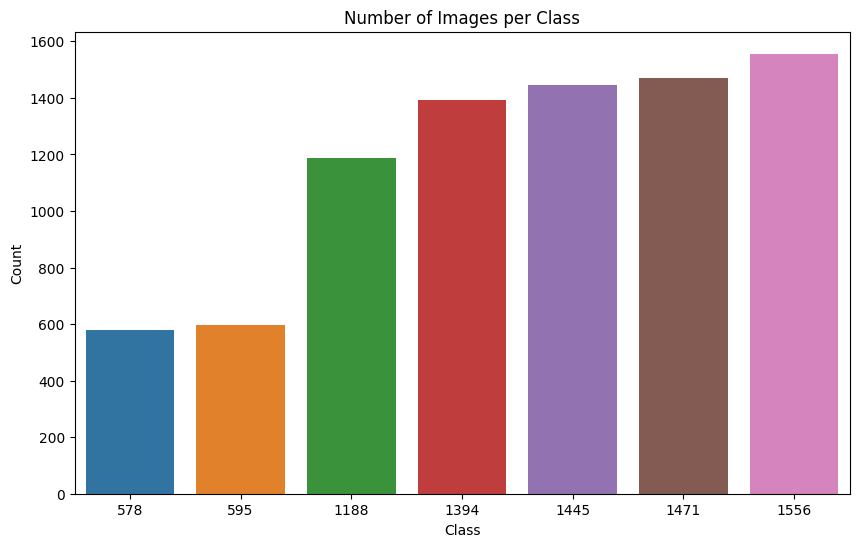

In [9]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=train_class_counts.values, y=train_class_counts.values)
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# C. Number of pixels in the first 2 images of each class

In [10]:
first_two_images_per_class = {}

# Loop over each class and get the first 2 images
for class_name in train_df['label'].unique():
    class_images = train_df[train_df['label'] == class_name]['image_ID'].head(2)
    first_two_images_per_class[class_name] = []
    for image_id in class_images:
        img_path = os.path.join(train_path, image_id)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        first_two_images_per_class[class_name].append((h, w))

print("First two images height and width per class:")
first_two_images_per_class


First two images height and width per class:


{'Badminton': [(285, 380), (172, 268)],
 'Cricket': [(900, 1200), (1152, 2048)],
 'Tennis': [(168, 299), (168, 300)],
 'Swimming': [(194, 259), (720, 1280)],
 'Soccer': [(168, 300), (188, 268)],
 'Wrestling': [(788, 1400), (576, 1024)],
 'Karate': [(168, 300), (183, 275)]}

# D) Display at Least 3 Images of Each Class

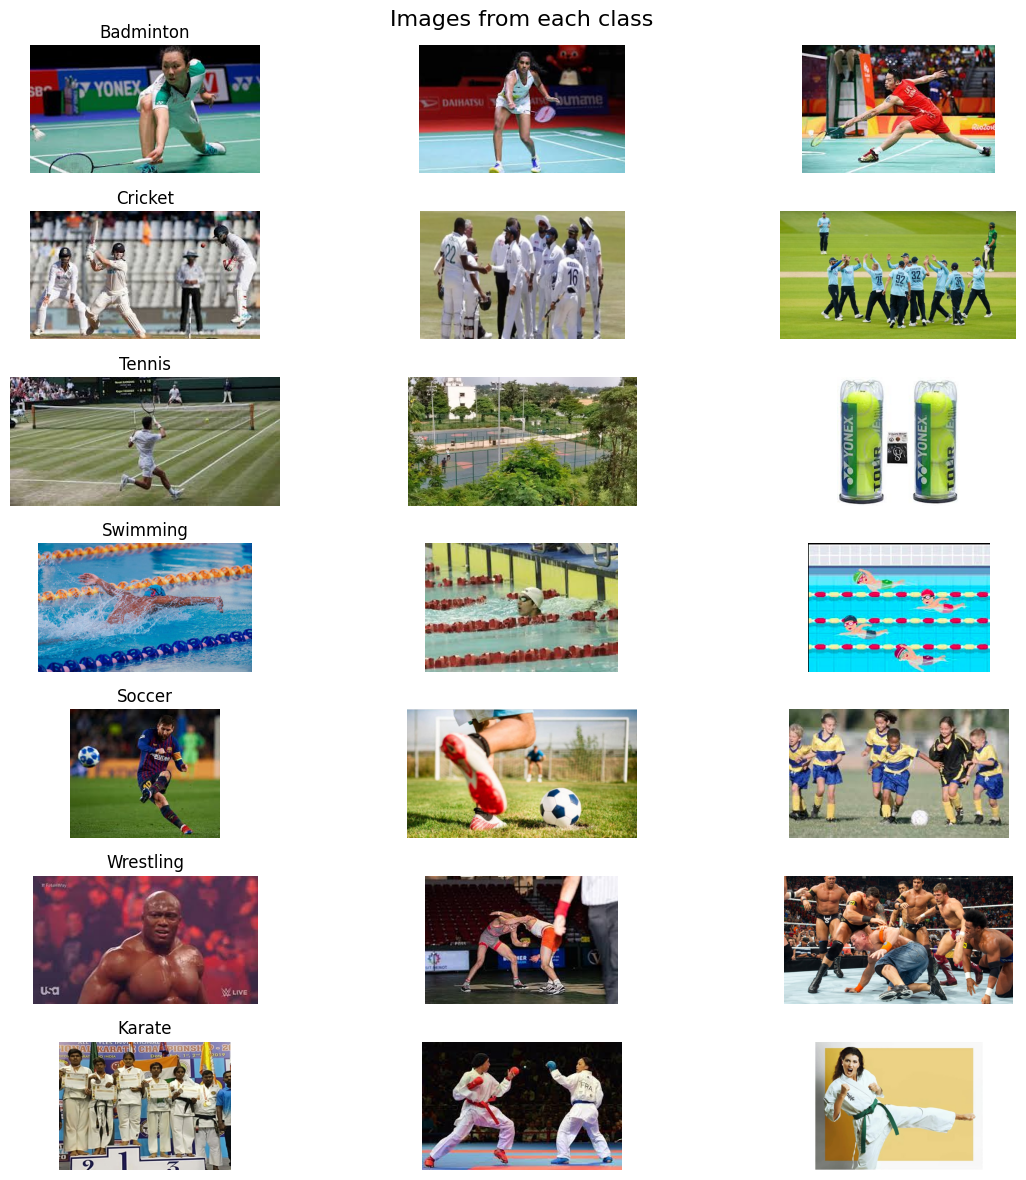

In [11]:
def display_images_per_class(df, folder_path, num_images=3):
    classes = df['label'].unique()
    fig, axes = plt.subplots(len(classes), num_images, figsize=(12, 12))
    fig.suptitle('Images from each class', size=16)

    for i, class_name in enumerate(classes):
        class_images = df[df['label'] == class_name].sample(num_images)['image_ID']
        for j, image_id in enumerate(class_images):
            img_path = os.path.join(folder_path, image_id)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Display 3 images from each class in the training set
display_images_per_class(train_df, train_path)

# E) Apply Data Augmentation and Preprocessing

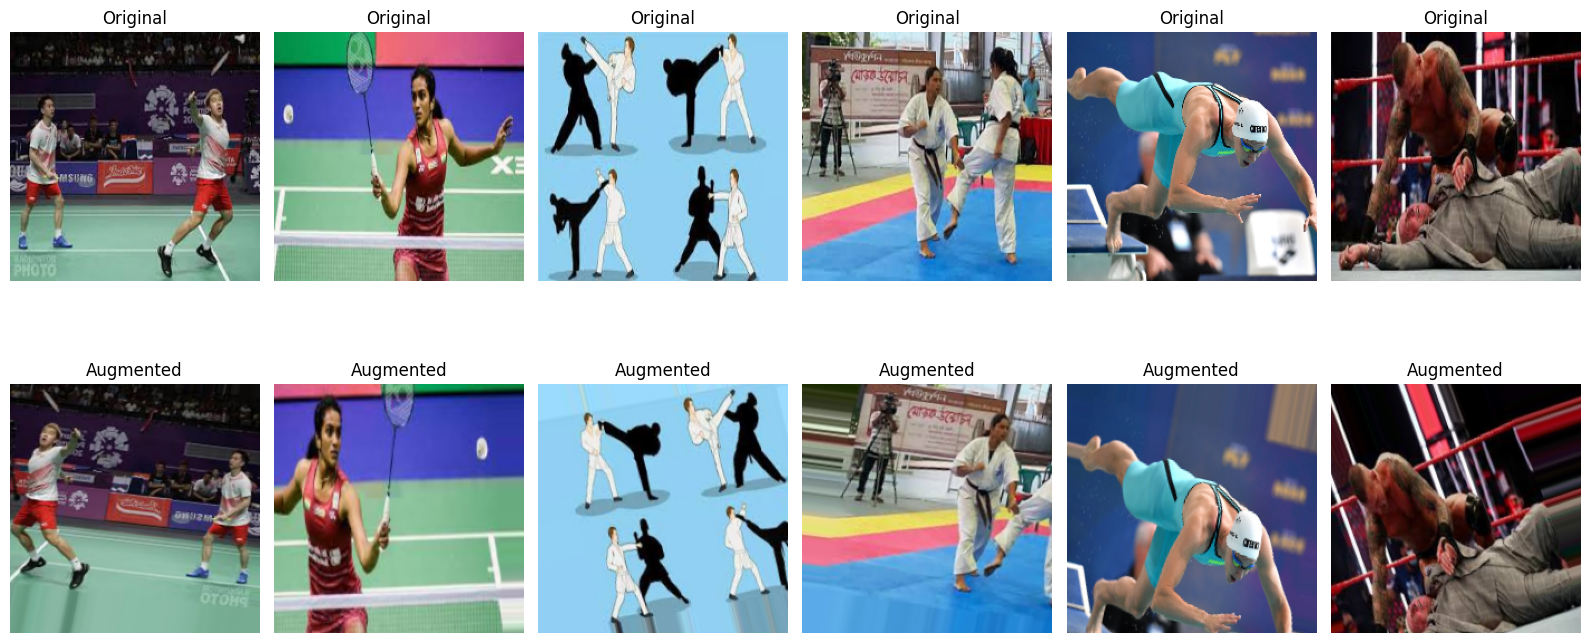

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a common target size for all images
target_size = (224, 224)

# Get some sample images to augment
sample_images = train_df.sample(6)['image_ID'].values
sample_images_paths = [os.path.join(train_path, img_id) for img_id in sample_images]

# Plot original and augmented images
fig, axes = plt.subplots(2, 6, figsize=(16, 8))  # 2 rows: one for original, one for augmented

for i, img_path in enumerate(sample_images_paths):
    # Load image and resize to target size
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)  # Resize image to (224, 224)
    
    # Display original resized image
    axes[0, i].imshow(img_resized)
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")
    
    # Apply augmentation
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    augmented_img = datagen.flow(img_resized)[0].astype('uint8')  # Remove batch dimension with [0]

    # Display augmented image (remove batch dimension)
    axes[1, i].imshow(augmented_img[0])  # Correct shape for displaying the image
    axes[1, i].axis('off')
    axes[1, i].set_title("Augmented")

plt.tight_layout()
plt.show()

# Training  a Neural Network

In [13]:
from sklearn.preprocessing import LabelBinarizer


def load_images_from_folder(df, folder_path):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_id = row['image_ID']
        img_path = os.path.join(folder_path, img_id)
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))  # Resize images to 224x224
            images.append(img)
            labels.append(row['label'])
        else:
            print(f"Image {img_id} not found in folder.")
    
    return np.array(images), np.array(labels)

# Load training images
train_images, train_labels = load_images_from_folder(train_df, train_path)  # Replace with your actual path

In [14]:
# Normalize the pixel values
train_images = train_images.astype('float32') / 255.0

# Encode labels to one-hot format
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)

# Split the dataset into training (70%), validation (10%), and testing (20%)
X_train, X_valid, y_train, y_valid = train_test_split(
    train_images, train_labels, 
    test_size=0.3, # 30% for validation + test
    stratify=train_labels, # Maintain class distribution
    random_state=42
)

# Further split the validation set to get 10% of original data as validation
X_val, X_test, y_val, y_test = train_test_split(
    X_valid, y_valid,
    test_size=2/3, # 2/3 of 30% is 20%, so 10% for validation
    stratify=y_valid, # Maintain class distribution
    random_state=42
)

# Check the shapes of the resulting datasets
print(f'Train images shape: {X_train.shape}, Train labels shape: {y_train.shape}')
print(f'Validation images shape: {X_valid.shape}, Validation labels shape: {y_valid.shape}')
print(f'Test images shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Train images shape: (5758, 224, 224, 3), Train labels shape: (5758, 7)
Validation images shape: (2469, 224, 224, 3), Validation labels shape: (2469, 7)
Test images shape: (1646, 224, 224, 3), Test labels shape: (1646, 7)


# 1. Number of Layers and Neurons

In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, models

def build_model1():
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))  # Output layer for 7 classes
    
    return model

# Build the model
model = build_model1()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

In [18]:
def build_model():
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))  # Output layer for 7 classes
    
    return model

# Build the model
model1 = build_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# 2. Epochs and Batch Sizes 

In [28]:
print(f"Training with epochs={10} and batch_size={64}")
model = build_model()  
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Training with epochs=10 and batch_size=64
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.2094 - loss: 2.8945 - val_accuracy: 0.3803 - val_loss: 1.5474
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.4502 - loss: 1.4292 - val_accuracy: 0.5565 - val_loss: 1.1489
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6202 - loss: 1.0657 - val_accuracy: 0.6574 - val_loss: 0.9442
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.7425 - loss: 0.7669 - val_accuracy: 0.6999 - val_loss: 0.9309
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.8168 - loss: 0.5439 - val_accuracy: 0.7254 - val_loss: 0.8787
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.8715 - loss: 0.3857 - val_accuracy: 0.7448 - val_loss: 0.8689
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9013 - loss: 0.2977 - val_accuracy: 0.7266 - val_loss: 1.0322
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - 

In [26]:
print(f"Training with epochs={20} and batch_size={32}")
model = build_model()  
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
best_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Training with epochs=20 and batch_size=32
Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.2413 - loss: 2.7215 - val_accuracy: 0.4253 - val_loss: 1.4369
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4766 - loss: 1.3645 - val_accuracy: 0.5516 - val_loss: 1.2149
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.6387 - loss: 1.0124 - val_accuracy: 0.6294 - val_loss: 1.0968
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.7625 - loss: 0.6871 - val_accuracy: 0.6841 - val_loss: 1.0633
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.8529 - loss: 0.4169 - val_accuracy: 0.7096 - val_loss: 1.1254
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9123 - loss: 0.2608 - val_accuracy: 0.7157 - val_loss: 1.2285
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9338 - loss: 0.2122 - val_accuracy: 0.7157 - val_loss: 1.4038
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82m

In [37]:
best_model = model
best_history # Best Model among all the models 

# 3 Activation Functions

In [35]:
# using tanh as we have already used relu activation in above code 
print(f"Training with activation function: 'tanh' ")
    
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
model.add(layers.Conv2D(128, (3, 3), activation='tanh'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
model.add(layers.Flatten())
        
# Dense layers
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(7, activation='softmax'))  # Output layer for 7 classes
        
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Training with activation function: 'tanh' 
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.1623 - loss: 2.2555 - val_accuracy: 0.1883 - val_loss: 1.8894
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.1808 - loss: 1.9474 - val_accuracy: 0.1883 - val_loss: 1.8911
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.1775 - loss: 1.9127 - val_accuracy: 0.1786 - val_loss: 1.8882
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.1811 - loss: 1.8993 - val_accuracy: 0.1883 - val_loss: 1.8885
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.1681 - loss: 1.9019 - val_accuracy: 0.1786 - val_loss: 1.8899
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.1825 - loss: 1.8937 - val_accuracy: 0.1883 - val_loss: 1.8931
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.1717 - loss: 1.9034 - val_accuracy: 0.1762 - val_loss: 1.8914
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 88

# 4. Regularizations  (L1 ,L2 , Dropout)

In [42]:
from tensorflow.keras.regularizers import l1, l2

# Try different regularizations
regularizations = [l2(0.01), l1(0.01)]  # one regularization is dropout used in between the layers

for reg in regularizations:
    
    print(f"Training with regularization: {reg}")
    
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
        
    # Dense layers
    model.add(layers.Dense(128, activation='relu',kernel_regularizer=reg))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=reg))
    model.add(layers.Dense(7, activation='softmax')) 
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Training with regularization: <keras.src.regularizers.regularizers.L2 object at 0x7d51447a5e70>
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.2343 - loss: 5.3203 - val_accuracy: 0.4034 - val_loss: 2.1115
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.3761 - loss: 2.0935 - val_accuracy: 0.4326 - val_loss: 1.9603
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4150 - loss: 2.0047 - val_accuracy: 0.4411 - val_loss: 1.8850
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4476 - loss: 1.8862 - val_accuracy: 0.4642 - val_loss: 1.9127
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4638 - loss: 1.8640 - val_accuracy: 0.4994 - val_loss: 1.8568
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4732 - loss: 1.7946 - val_accuracy: 0.5006 - val_loss: 1.6929
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5156 - loss: 1.6933 - val_accuracy: 0.5018 - val_loss: 

# 5. Loss Functions

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop

# Different optimizers to try
optimizers = [Adam(), SGD(), RMSprop()]

for optimizer in optimizers:
    optimizer_name = optimizer.__class__.__name__
    print(f"Training with optimizer: {optimizer_name}")
    model = build_model([128, 64])  # Use the layer configuration of your choice
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
import tensorflow as tf

# Different loss functions to try
loss_functions = 'sparse_categorical_crossentropy'

from tensorflow.keras.utils import to_categorical

# If your labels are not one-hot encoded, convert them
y_train_encoded = to_categorical(y_train, num_classes=7)
y_val_encoded = to_categorical(y_val, num_classes=7)


print(f"Training with loss function: {loss_functions}")

model = models.Sequential()
    
# Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
    
# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))  # Output layer for 7 classes

model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=10, batch_size=32)

# 6. Optimization Algorithms

In [22]:
from tensorflow.keras.optimizers import SGD, RMSprop

# Different optimizers to try
optimizers = [SGD(), RMSprop()]

for optimizer in optimizers:
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
        
    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(7, activation='softmax')) 
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
    print("----------------------------------------------------------------------------------")

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.2084 - loss: 1.9084 - val_accuracy: 0.3925 - val_loss: 1.6489
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.3559 - loss: 1.6806 - val_accuracy: 0.4787 - val_loss: 1.4181
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4457 - loss: 1.4756 - val_accuracy: 0.5662 - val_loss: 1.2200
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5196 - loss: 1.3243 - val_accuracy: 0.5711 - val_loss: 1.2200
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.5559 - loss: 1.2144 - val_accuracy: 0.6574 - val_loss: 1.0149
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.6158 - loss: 1.0813 - val_accuracy: 0.6488 - val_loss: 1.0252
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.6427 - loss: 1.0105 - val_accuracy: 0.6877 - val_loss: 0.9138
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.6671 - loss: 0.9424 - 

In [23]:
best_model.save('best_model.h5')

# Create a Graph of Loss vs. Epochs for Training and Validation Set

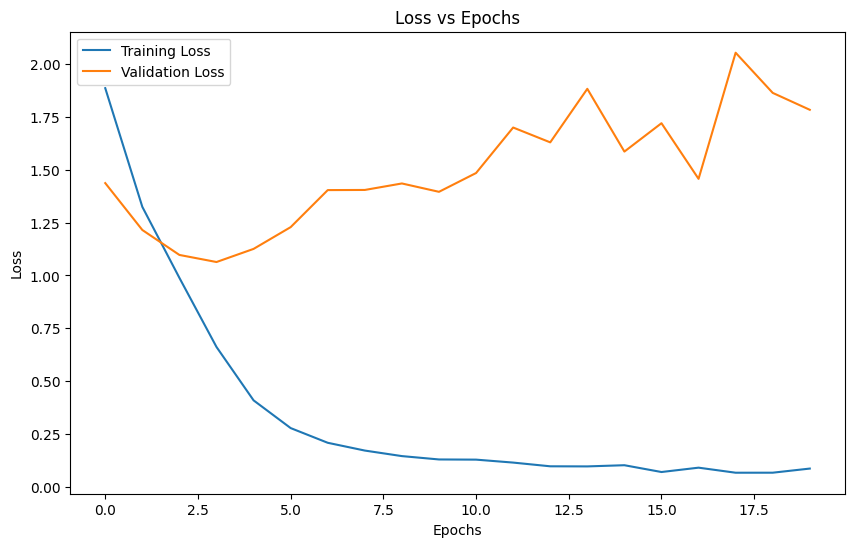

In [29]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example call to plot_loss
plot_loss(best_history) 

# Create a Graph of F1 Score vs. Epochs for Training and Validation Set

In [ ]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import numpy as np

class F1ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate F1 for training set
        y_train_pred = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        y_train_true = np.argmax(self.validation_data[1], axis=-1)
        f1_train = f1_score(y_train_true, y_train_pred, average='macro')

        # Calculate F1 for validation set
        y_val_pred = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        y_val_true = np.argmax(self.validation_data[1], axis=-1)
        f1_val = f1_score(y_val_true, y_val_pred, average='macro')

        # Append to logs for later access
        logs['f1_train'] = f1_train
        logs['f1_val'] = f1_val

        print(f"Epoch {epoch+1}: F1-Train: {f1_train:.4f}, F1-Validation: {f1_val:.4f}")

# Instantiate the F1ScoreCallback
f1_callback = F1ScoreCallback()

# Train the model and pass the F1 score callback
history = best_model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Example number of epochs
    batch_size=32,  # Example batch size
    callbacks=[f1_callback]
)


import matplotlib.pyplot as plt

def plot_f1_scores(history):
    # Extract F1 scores for training and validation
    f1_train_scores = [log['f1_train'] for log in history.history]
    f1_val_scores = [log['f1_val'] for log in history.history]

    # Plot F1 scores
    plt.figure(figsize=(10, 6))
    plt.plot(f1_train_scores, label='Training F1 Score')
    plt.plot(f1_val_scores, label='Validation F1 Score')
    plt.title('F1 Score vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

# Call the plot function with the history
# plot_f1_scores(history)

#  Calculate the Number of Trainable Parameters in the Final Model

In [39]:
# Calculate the number of trainable parameters
trainable_params = best_model.count_params()
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 47860231


# Display Some Predicted Images from the Test Dataset

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


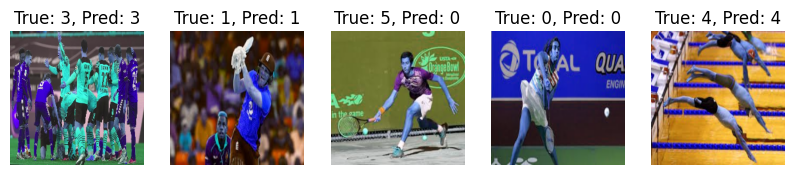

In [42]:
import numpy as np

# Predict on test data
test_predictions = best_model.predict(X_test)

# Get the class with the highest probability
predicted_classes = np.argmax(test_predictions, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Display a few test images and their predicted classes
def display_predictions(X_test_images, y_test_encoded, predicted_classes, actual_classes, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X_test_images[i])
        plt.title(f"True: {actual_classes[i]}, Pred: {predicted_classes[i]}")
        plt.axis('off')
    plt.show()

# Example call to display_predictions
display_predictions(X_test, y_test, predicted_classes, actual_classes, num_images=5)